# Data Importation

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import namedtuple
from scipy.signal import butter, filtfilt
from scipy.io import loadmat
from collections import namedtuple
from math import floor
from scipy import stats
import antropy as ant
import pywt
from vmdpy import VMD
import warnings

In [2]:
warnings.filterwarnings('ignore')

In [33]:
# import the data for patient 1
EEG_78_CH2 = pd.read_csv('EEG_78_CH2.csv')
bis_78 = pd.read_csv('bis_78.csv')
B78=bis_78['BIS/BIS']
E78=np.ravel(EEG_78_CH2['BIS/EEG2_WAV'])
print ('The shape of EEG signals and BIS for patient 78 is {} and {} '.format(E78.shape,B78.shape) )

The shape of EEG signals and BIS for patient 78 is (535191,) and (4180,) 


In [34]:
# Handling missing values
E78_copy = np.copy(E78)
def handle_missing_values(signal):
    # Interpolate missing values using linear interpolation
    mask = np.isnan(signal)
    signal[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), signal[~mask])
    return signal
handle_missing_values(E78_copy)

array([-5.6, -5.6, -5.6, ..., -6.5, -6.5, -6.5])

In [35]:
bis_list = B78.tolist()

<br/>

# Windowing

In [36]:
# Generate the windows
def generate_samples(bis, eeg, window_size=600, sampling_rate=128, verbose=False):
    """
    Generates EEG samples for consecutive windows 
    and their corresponding BIS value
    
    
    Parameters
    ----------       
    bis: (n,) array
        BIS Sample
        
    eeg: (n,) array. 
        EEG Sample. 
        
    window_size: int, default=60 
        Duration of each window in seconds
        
    sampling_rate: float default=128
        Sampling rate of the EEG sample in Hz.
        
    verbose: Bool; default=False
        Provides feedback on the sampling process
        
    
    Generates
    ---------
    tup: tuple(bis_mode, eeg_sample)
    
        bis_mode: float
            Modal BIS value of the EEG Sample
        
        eeg_sample: array
            EEG Sample for a 5 second window
        
        
        
    Example
    -------
    >>> awake = np.array([82.8])
    >>> eeg = array([ 0.17727497,  0.17783894,  0.17834346,  0.17878847,  0.17917353,
        0.17949788,  0.17976084,  0.17996202,  0.18010136,  0.18017881, ...])
       
    >>> # Create the generator
    >>> gen_sample = generate_samples(bis, eeg)
    
    >>> # Generate EEG sample
    >>> sample = next(gen_sample)
    
    
    Notes
    -----
    generate_samples works well with the generate_DFTParameters and generate_DWTParameters functions.
    
    >>> generate_DFTParameters(sample)
    [0.075986      0.206614     0.405465      1.290984      0.980829       84.5]
    
    """
    
    bis_len = len(bis)
    
    if bis_len < window_size:
        print("Length of BIS values must be greater than {}".format(window_size))
        return    

    
    start, end = 0, window_size
    
    eeg_start, eeg_end = 0, end * sampling_rate
    
    
    while True:
        if end > bis_len:
            break
        
        bis_idx = bis[start:end][1]
        
        eeg_sample = eeg[eeg_start:eeg_end]
        
        data = namedtuple('EEG_Sample', ['eeg', 'bis'])
        
        tup = data(eeg_sample, bis_idx)
        
        if verbose:
            print("EEG Start: {} - {}".format(eeg_start, eeg_end))
        
        yield tup
        
        # update ranges
        start += 1
        end += 1
        
        eeg_start = start * sampling_rate
        eeg_end = end * sampling_rate
        
        

<br/>

## Testing <code>generate_samples</code>

We have to make sure that 60th BIS value for this patient - **82.9**, is the first value generated by the generator.

In [37]:
# -----
# TEST
# -----

# Get the data
bis = bis_list
eeg_sample = E78_copy
# Create the generator
test_generator = generate_samples(bis, eeg_sample, verbose=True)

test_sample = next(test_generator)

print("First BIS index: ", test_sample.bis)
print("First EEG index: ", test_sample.eeg," and the shape is", test_sample.eeg.shape)

 #Check that BIS values are only recorded after 60 seconds
 #The 60th BIS is 82.9 for this patient
#assert test_sample.bis == bis[200] == 74.8

EEG Start: 0 - 76800
First BIS index:  0.0
First EEG index:  [ -5.6  -5.6  -5.6 ... -20.6 -20.2 -18.3]  and the shape is (76800,)


In [38]:
102400-25600

76800

<br/>

# Feature Extraction

## DFT <code>generate_DFTParameters</code>

In [39]:
def generate_DFTParameters(eeg_sample, sampling_rate=128, method="samp_ent"):
    """
    Generate the DFT parameters of EEG segments
    
    
    Parameters
    ----------
    eeg_sample: namedtuple('EEG_Sample', ['eeg', 'bis'])
    
        eeg: (n,) array 
            EEG Data
            
        bis: float
            Bispectral Index
            
        
    sampling_rate: int
        Sampling rate of the EEG segment
    
    
    method: String; default="samp_ent"; Values can be "samp_ent", "perm_ent", "hig", or "katz"
    
        Feature extraction methods implemented here are 
        - Sample entropy
        - Permutation entropy
        - Higuchi's Fractal Dimension
        - Katz's Fractal Dimension
        
        
        
    Returns
    -------
    df : namedtuple
        namedtuple of EEG parameters
        
    
    Notes
    -----
    Works well with the generate_samples function. See the documentation on generate_samples.
    """
    
    # amplitudes
    fft_values = np.absolute(np.fft.rfft(eeg_sample.eeg))

    # frequencies
    fft_freq = np.fft.rfftfreq(len(eeg_sample.eeg), 1.0/sampling_rate)
    
    # Analysing the bands
    eeg_bands = {'Delta': (0, 4),
                 'Theta': (4, 8),
                 'Alpha': (8, 12),
                 'Beta': (12, 30),
                 'Gamma': (30, 45)}

    eeg_band_fft = dict()

    for band in eeg_bands.keys():
        freq_idx = np.where((fft_freq >= eeg_bands[band][0]) & (fft_freq <= eeg_bands[band][1]))

        # sum the amplitudes of the bands
        eeg_band_fft[band] = fft_values[freq_idx]
        

    # Sample entropy
    if method == "samp_ent":
        # Sample entropy of the delta band
        sampen_delta = ant.sample_entropy(eeg_band_fft['Delta'])
        sampen_beta = ant.sample_entropy(eeg_band_fft['Beta'])
        sampen_theta = ant.sample_entropy(eeg_band_fft['Theta'])
        sampen_gamma = ant.sample_entropy(eeg_band_fft['Gamma'])
        sampen_alpha = ant.sample_entropy(eeg_band_fft['Alpha'])

        # Create the namedtuple
        Parameters = namedtuple('Parameters', ["Sampen_Delta", "Sampen_Beta", "Sampen_Theta", "Sampen_Gamma", "Sampen_Alpha", "BIS"])

        return Parameters(sampen_delta, sampen_beta, sampen_theta, sampen_gamma, sampen_alpha, eeg_sample.bis)


    # Permutation Entropy
    if method == "perm_ent":
        permen_delta = ant.perm_entropy(eeg_band_fft['Delta'])
        permen_beta = ant.perm_entropy(eeg_band_fft['Beta'])
        permen_theta = ant.perm_entropy(eeg_band_fft['Theta'])
        permen_gamma = ant.perm_entropy(eeg_band_fft['Gamma'])
        permen_alpha = ant.perm_entropy(eeg_band_fft['Alpha'])

        # Create the namedtuple
        Parameters = namedtuple('Parameters', ["Permen_Delta", "Permen_Beta", "Permen_Theta", "Permen_Gamma", "Permen_Alpha", "BIS"])

        return Parameters(permen_delta, permen_beta, permen_theta, permen_gamma, permen_alpha, eeg_sample.bis)


    # Higuchi Fractal Dimension
    if method == "hig":
        hig_delta = ant.higuchi_fd(eeg_band_fft['Delta'])
        hig_beta = ant.higuchi_fd(eeg_band_fft['Beta'])
        hig_theta = ant.higuchi_fd(eeg_band_fft['Theta'])
        hig_gamma = ant.higuchi_fd(eeg_band_fft['Gamma'])
        
        hig_alpha = ant.higuchi_fd(eeg_band_fft['Alpha'])

        # Create the namedtuple
        Parameters = namedtuple('Parameters', ["Hig_Delta", "Hig_Beta", "Hig_Theta", "Hig_Gamma", "Hig_Alpha", "BIS"])

        return Parameters(hig_delta, hig_beta, hig_theta, hig_gamma, hig_alpha, eeg_sample.bis)


    # Katz Fractal Dimension
    if method == "katz":
        # Sample entropy of the delta band
        katz_delta = ant.katz_fd(eeg_band_fft['Delta'])
        katz_beta = ant.katz_fd(eeg_band_fft['Beta'])
        katz_theta = ant.katz_fd(eeg_band_fft['Theta'])
        katz_gamma = ant.katz_fd(eeg_band_fft['Gamma'])
        katz_alpha = ant.katz_fd(eeg_band_fft['Alpha'])

        # Create the namedtuple
        Parameters = namedtuple('Parameters', ["Katz_Delta", "Katz_Beta", "Katz_Theta", "Katz_Gamma", "Katz_Alpha", "BIS"])

        return Parameters(katz_delta, katz_beta, katz_theta, katz_gamma, katz_alpha, eeg_sample.bis)
    
    if method == 'mean':
        # Sample entropy of the delta band
        mean_delta = np.mean(eeg_band_fft['Delta'])
        mean_beta = np.mean(eeg_band_fft['Beta'])
        mean_theta =np.mean(eeg_band_fft['Theta'])
        mean_gamma = np.mean(eeg_band_fft['Gamma'])
        mean_alpha = np.mean(eeg_band_fft['Alpha'])

        # Create the namedtuple
        Parameters = namedtuple('Parameters', ["mean_Delta", "mean_Beta", "mean_Theta", "mean_Gamma", "mean_Alpha", "BIS"])

        return Parameters(mean_delta, mean_beta, mean_theta, mean_gamma, mean_alpha, eeg_sample.bis)
    
    
    # All parameters
    if method == "all":
        # Let's hope we never have to do this
        pass
    

In [40]:
generate_DFTParameters(test_sample)

Parameters(Sampen_Delta=0.5065701004368967, Sampen_Beta=1.66929080412263, Sampen_Theta=1.940237684798296, Sampen_Gamma=1.513319125604912, Sampen_Alpha=1.9295514260237991, BIS=0.0)

<br/>

## DWT <code>generate_DWTParameters</code>

In [41]:
def generate_DWTParameters(eeg_sample, wavelet="db4", method="mean"):
    
    """
    Generate the DWT Parameters of an EEG Sample
    
    
    Parameters
    -----------
    eeg_sample: namedtuple('EEG_Sample', ['eeg', 'bis'])
    
        bis: float
            Bispectral Index
            
        eeg: (n,) array 
            EEG Data
            
            
    wavelet: String; default="db4"
        Wavelet to use
    
    
    method: String; default="samp_ent"; Values can be "samp_ent", "perm_ent", "hig", or "katz"
    
        Feature extraction method: Methods implemented here are 
        - Sample entropy
        - Permutation entropy
        - Higuchi's Fractal Dimension
        - Katz's Fractal Dimension
        
        
        
    Returns
    -------
    df : namedtuple
        namedtuple of EEG parameters
        
    
    Notes
    -----
    Works well with the generate_samples function. See the documentation on generate_samples.
    """
    
    # Approximate and Detailed Coefficients
    cA_4, cD_4, cD_3, cD_2, cD_1 = pywt.wavedec(eeg_sample.eeg, wavelet, level=4)
    
    
    # Introduced a new method parameter: The parameters are calculated based on the method selected
    if method == "samp_ent":
        # Sample Entropy of the sub-bands
        sampen_cA_4 = ant.sample_entropy(cA_4)
        sampen_cD_4 = ant.sample_entropy(cD_4)
        sampen_cD_3 = ant.sample_entropy(cD_3)
        sampen_cD_2 = ant.sample_entropy(cD_2)
        sampen_cD_1 = ant.sample_entropy(cD_1)

        # Create the namedtuple 
        Parameters = namedtuple('Parameters', ["SampenCA_4", "SampenCD_4", "SampenCD_3", "SampenCD_2", "SampenCD_1", "BIS"])

        return Parameters(sampen_cA_4, sampen_cD_4, sampen_cD_3, sampen_cD_2, sampen_cD_1, eeg_sample.bis)
        
        
    # Permutation Entropy: variables -> order, delay, normalize
    # Use default values in the meantime
    if method == "perm_ent":
        perment_cA_4 = ant.perm_entropy(cA_4)
        perment_cD_4 = ant.perm_entropy(cD_4)
        perment_cD_3 = ant.perm_entropy(cD_3)
        perment_cD_2 = ant.perm_entropy(cD_2)
        perment_cD_1 = ant.perm_entropy(cD_1)

        # Create the namedtuple
        Parameters = namedtuple('Parameters', ['Permen_cA_4', 'Permen_cD_4', 'Permen_cD_3', 'Permen_cD_2', 'Permen_cD_1', 'BIS'])

        return Parameters(perment_cA_4, perment_cD_4, perment_cD_3, perment_cD_2, perment_cD_1, eeg_sample.bis)
        
        
    # Higuchi's Fractal Dimension: variable -> kmax
    # Use default value in the meantime
    if method == "hig":        
        hig_cA_4 = ant.higuchi_fd(cA_4)
        hig_cD_4 = ant.higuchi_fd(cD_4)
        hig_cD_3 = ant.higuchi_fd(cD_3)
        hig_cD_2 = ant.higuchi_fd(cD_2)
        hig_cD_1 = ant.higuchi_fd(cD_1)

        
        # Create the namedtuple
        Parameters = namedtuple('Parameters', ['Hig_cA_4', 'Hig_cD_4', 'Hig_cD_3', 'Hig_cD_2', 'Hig_cD_1', 'BIS'])

        return Parameters(hig_cA_4, hig_cD_4, hig_cD_3, hig_cD_2, hig_cD_1, eeg_sample.bis)
        
        
    # Katz Fractal Dimension        
    if method == "katz":
        katz_cA_4 = ant.katz_fd(cA_4)
        katz_cD_4 = ant.katz_fd(cD_4)
        katz_cD_3 = ant.katz_fd(cD_3)
        katz_cD_2 = ant.katz_fd(cD_2)
        katz_cD_1 = ant.katz_fd(cD_1)

        # Create the namedtuple
        Parameters = namedtuple('Parameters', ['Katz_cA_4', 'Katz_cD_4', 'Katz_cD_3', 'Katz_cD_2', 'Katz_cD_1', 'BIS'])

        return Parameters(katz_cA_4, katz_cD_4, katz_cD_3, katz_cD_2, katz_cD_1, eeg_sample.bis)
    
        # Katz Fractal Dimension        
    if method == "mean":
        mean_cA_4 = np.mean(cA_4)
        mean_cD_4 = np.mean(cD_4)
        mean_cD_3 = np.mean(cD_3)
        mean_cD_2 = np.mean(cD_2)
        mean_cD_1 = np.mean(cD_1)

        # Create the namedtuple
        Parameters = namedtuple('Parameters', ['mean_cA_4', 'mean_cD_4', 'mean_cD_3', 'mean_cD_2', 'mean_cD_1', 'BIS'])

        return Parameters(mean_cA_4, mean_cD_4, mean_cD_3, mean_cD_2, mean_cD_1, eeg_sample.bis)
    
    # All parameters
    if method == "all":
        # Let's hope we never have to do this
        pass

In [42]:
generate_DWTParameters(test_sample)

Parameters(mean_cA_4=-53.77704458058217, mean_cD_4=0.10537937154553981, mean_cD_3=-0.017223165805808995, mean_cD_2=0.08390882373545785, mean_cD_1=-0.06707942739515879, BIS=0.0)

# Dataset Creation

In this section, the essential functions - <code>generate_samples</code>, <code>generate_DFTParameters</code>, and <code>generate_DWTParameters</code> are tested in the creation of the DFT and DWT datasets.

## DFT

In [43]:
# -----
# TEST
# -----
bis = bis_list
eeg_sample = E78_copy

# Generator that creates EEG samples: Read the docs if anything goes wrong
test_gen = generate_samples(bis_list, E78_copy)

# Generate the dataset: Use the permutation entropy
df_dft = pd.DataFrame(data=[generate_DFTParameters(sample, method="perm_ent") for sample in test_gen])

# Modify index
df_dft.index = df_dft.index + 200

df_dft.head()

,Permen_Delta,Permen_Beta,Permen_Theta,Permen_Gamma,Permen_Alpha,BIS
200,2.579538,2.572132,2.567355,2.470553,2.570891,0.0
201,2.579865,2.572307,2.567667,2.469947,2.571703,0.0
202,2.579212,2.572088,2.567320,2.469639,2.570612,0.0
203,2.579397,2.571767,2.567686,2.469335,2.569989,0.0
204,2.579299,2.571828,2.566860,2.470260,2.571638,0.0


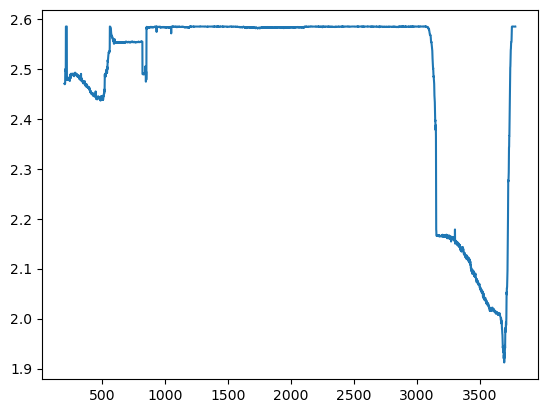

In [44]:
plt.plot(df_dft['Permen_Gamma'])

## DWT

In [45]:
# -----
# TEST
# -----

# The data
bis = bis_list
denoised = E78_copy

# Generator that creates EEG samples: Read the docs if anything goes wrong
test_gen = generate_samples(bis_list, E78_copy)

# Creating the dataset
dwt_dataset = [generate_DWTParameters(sample, method="mean") for sample in test_gen]

# Dataset
df_dwt = pd.DataFrame(data=dwt_dataset)

# Modify index
df_dwt.index = df_dwt.index + 200

df_dwt.head()


,mean_cA_4,mean_cD_4,mean_cD_3,mean_cD_2,mean_cD_1,BIS
200,-53.777045,0.105379,-0.017223,0.083909,-0.067079,0.0
201,-53.856790,0.111940,-0.015900,0.083719,-0.067099,0.0
202,-53.800732,0.110168,-0.021743,0.083607,-0.067005,0.0
203,-53.845990,0.102692,-0.023254,0.082975,-0.067050,0.0
204,-53.875013,0.111784,-0.027428,0.083300,-0.067023,0.0


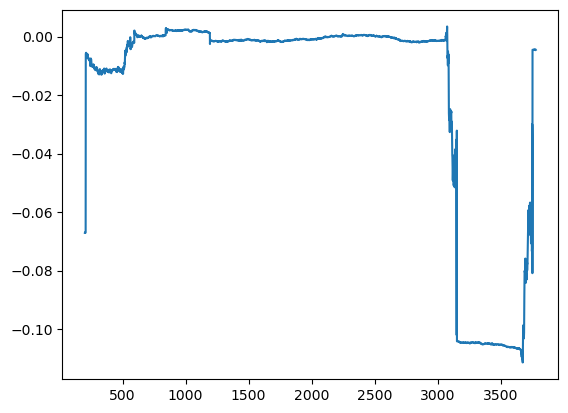

In [46]:
plt.plot(df_dwt['mean_cD_1'])

## <br/>

In [52]:
# Assuming BIS and EEG are numpy arrays
BIS = B78
EEG = E78_copy

# Define the sampling frequency
fs = 128

# Define the indices for BIS range from 200 to 800
bis_start_index = 200
bis_end_index = 800

# Convert the BIS indices to EEG indices

eeg_start_index = bis_start_index * fs
eeg_end_index = bis_end_index * fs

# Select EEG values for BIS[200:800]
selected_EEG = EEG[eeg_start_index:eeg_end_index]
selected_bis = BIS[bis_start_index:bis_end_index]
selected_bis = np.array(selected_bis)
print(selected_EEG)

[-14.8  -12.6  -13.1  ... -21.3  -21.8  -20.45]


In [57]:

sampling_rate=128

fft_values = np.absolute(np.fft.rfft(selected_EEG))

# frequencies
fft_freq = np.fft.rfftfreq(len(selected_EEG), 1.0/sampling_rate)
    
# Analysing the bands
eeg_bands = {'Delta': (0, 4),
                 'Theta': (4, 8),
                 'Alpha': (8, 12),
                 'Beta': (12, 30),
                 'Gamma': (30, 45)}

eeg_band_fft = dict()

for band in eeg_bands.keys():
    freq_idx = np.where((fft_freq >= eeg_bands[band][0]) & (fft_freq <= eeg_bands[band][1]))

    # sum the amplitudes of the bands
    eeg_band_fft[band] = fft_values[freq_idx]

In [50]:
test_sample

EEG_Sample(eeg=array([ -5.6,  -5.6,  -5.6, ..., -20.6, -20.2, -18.3]), bis=0.0)

In [58]:
eeg_bands['Alpha']

(8, 12)

In [62]:
eeg_band_fft['Gamma'].shape

(9001,)

In [ ]:
svm(train)